In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
#image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/resnet_v2_152.ckpt'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.luong.fromimg.resnet152'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.batch32/'

FLAGS.model_dir = model_dir

image_model_name = melt.image.get_imagenet_from_checkpoint(image_model_checkpoint_path).name
FLAGS.image_model_name = image_model_name
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, feature_name='attention')
else:
  image_model = None
print('image_model', image_model)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


ENCODE_UNK 1
checkpoint /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt model_name InceptionResnetV2 height 299 width 299
build graph for final one feature
preprocessing_fn net_name inception_resnet_v2 height 299 width 299


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
build graph for attention features
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten_1/flatten/Reshape:0", shape=(?, 98304), dtype=float32)


INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt
image_model <melt.image.image_model.ImageModel object at 0x7f72bad13690>


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 6.16463518143


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True
elif 'coverageV2' in model_dir:
  FLAGS.coverage_v2_attention_wrapper = True
else:
  FLAGS.attention_option = 'bahdanau' if 'bahdanau' in model_dir else 'luong'

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_endpoint_feature_name = 'attention'
FLAGS.image_checkpoint_file = image_model_checkpoint_path 
FLAGS.pre_calc_image_feature = 1 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.alignment_history = True

FLAGS.image_attention_size = FLAGS.image_attention_size or melt.image.get_num_features(FLAGS.image_model_name)
FLAGS.image_feature_len = FLAGS.image_feature_len or melt.image.get_feature_dim(FLAGS.image_model_name) * FLAGS.image_attention_size

beam_size = 10
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init(FLAGS.image_model_name)
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.batch32/model.ckpt-0.76-25000


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.batch32/model.ckpt-0.76-25000
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.batch32/model.ckpt-0.76-25000 duration: 0.682810783386


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 3:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 601013467957beaa6f85ffbbe46b1093b764ea5c


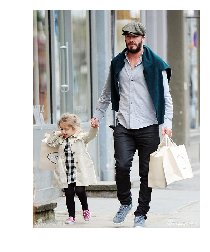

一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 女人 走 在 道路 上 </S> 0.0202953
probs [0.5647148089291795, 0.2770307756308712, 0.5938108066882994, 0.979779553744265, 0.6070305591661121, 0.5782626808571072, 0.983084047287883, 0.1716224002515789, 0.5450000696412096, 0.9939063079949283, 0.6057388326691593, 0.5897239523236846, 0.9976142478528613, 0.41360505544469345, 0.9860485653644117, 0.9705834328161468, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


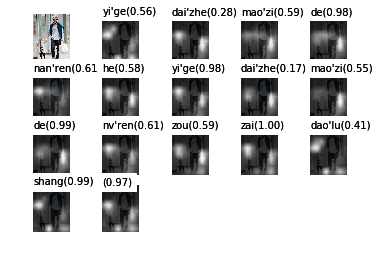

beam search using time(ms): 2618.50714684
一个 戴着 帽子 的 男人 和 一个 右手 拎 着 包 的 女人 走 在 道路 上 </S> 0.0180105
probs [0.5647148089291795, 0.2770307756308712, 0.5938108066882994, 0.979779553744265, 0.6070305591661121, 0.5782626808571072, 0.983084047287883, 0.15268882000874265, 0.3776974126494475, 0.9996659679836566, 0.44521643528317695, 0.9973090775353713, 0.8604000593207196, 0.7688295024686397, 0.9975526768579287, 0.4948746999953797, 0.9903793300903305, 0.981199254522353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


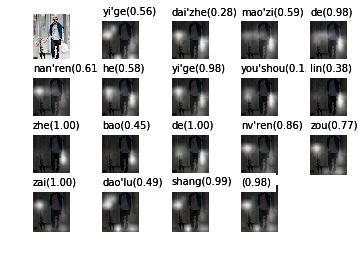

beam search using time(ms): 1542.9828167
一个 戴着 帽子 的 男人 和 一个 左手 拎 着 包 的 女人 走 在 道路 上 </S> 0.017615
probs [0.5647148089291795, 0.2770307756308712, 0.5938108066882994, 0.979779553744265, 0.6070305591661121, 0.5782626808571072, 0.983084047287883, 0.15237461446453096, 0.3732961254985599, 0.9996078360949902, 0.431131748282822, 0.9972950866390013, 0.8642354467024547, 0.7726374948798373, 0.9975454407979576, 0.49050190832701557, 0.9901574529469522, 0.98118479445174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


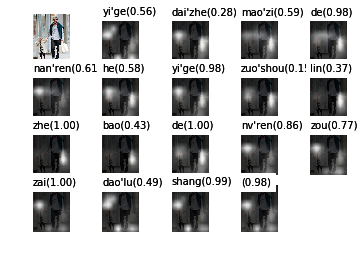

beam search using time(ms): 1541.56708717
一个 戴着 帽子 的 男人 和 一个 右手 拿 着 手机 的 女人 走 在 道路 上 </S> 0.0168576
beam search using time(ms): 43.0769920349
一个 戴着 帽子 的 男人 和 一个 左手 拿 着 手机 的 女人 走 在 道路 上 </S> 0.0163242
beam search using time(ms): 22.2430229187
一个 戴着 帽子 的 男人 和 一个 左手 拎 着 袋子 的 女人 走 在 道路 上 </S> 0.0156206
beam search using time(ms): 21.7170715332
一个 戴着 帽子 的 男人 和 一个 右手 拎 着 袋子 的 女人 走 在 道路 上 </S> 0.0155635
beam search using time(ms): 44.2559719086
一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 女人 走 在 房屋 外 的 道路 上 </S> 0.0117584
beam search using time(ms): 38.9578342438
一个 左手 拎 着 袋子 的 女人 和 一个 戴着 帽子 的 男人 走 在 道路 上 </S> 0.0113836


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


beam search using time(ms): 38.4562015533
一个 左手 拎 着 包 的 女人 和 一个 戴着 帽子 的 男人 走 在 道路 上 </S> 0.0113678
beam search using time(ms): 34.5118045807
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: d61c36f810ff9f08a51cb9b5c050b657cdead4ac


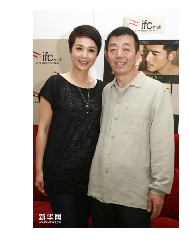

一个 右手 插 兜 的 男人 搂 着 一个 穿着 裙子 的 女人 站 在 广告牌 前 </S> 0.0116138
probs [0.5219835602091241, 0.0841265662744436, 0.7761418605607996, 0.6172712832855718, 0.9892696554448827, 0.9264898794862799, 0.5446275019684235, 0.99997663552505, 0.9763980904313502, 0.3155731851294486, 0.19856502305470372, 0.9957117938240364, 0.9831436141391963, 0.9577702792405521, 0.9963252183292463, 0.19019595547691895, 0.9442075459080205, 0.958817169564956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


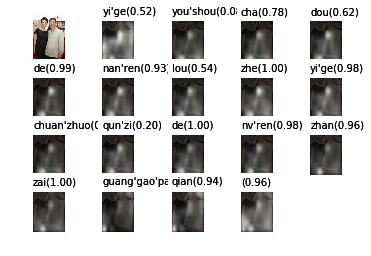

beam search using time(ms): 2221.80914879
一个 右手 插 兜 的 男人 搂 着 一个 面带微笑 的 女人 站 在 广告牌 前 </S> 0.0113231
probs [0.5219835602091241, 0.0841265662744436, 0.7761418605607996, 0.6172712832855718, 0.9892696554448827, 0.9264898794862799, 0.5446275019684235, 0.99997663552505, 0.9763980904313502, 0.09442813498178085, 0.9831467254339342, 0.6734706189176425, 0.9356140551538191, 0.9949666969244672, 0.20918832440355517, 0.9423731383014493, 0.9504036934792477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


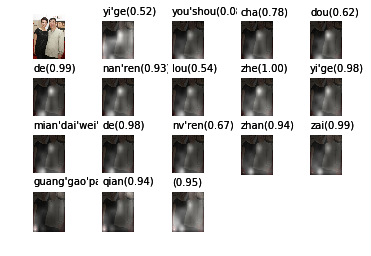

beam search using time(ms): 1563.38596344
一个 左手 插 兜 的 男人 搂 着 一个 穿着 裙子 的 女人 站 在 广告牌 前 </S> 0.0108171
probs [0.5219835602091241, 0.07310757672049482, 0.803673249350789, 0.6081204470026775, 0.9908052423435042, 0.927216465360604, 0.5336958609505527, 0.9999761587100603, 0.9762415070927981, 0.3141311206749454, 0.198504482391279, 0.9957249132956747, 0.9830468356315009, 0.9579434164731698, 0.9963075867582499, 0.18961880429565273, 0.9445258511371926, 0.9585302339996297, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


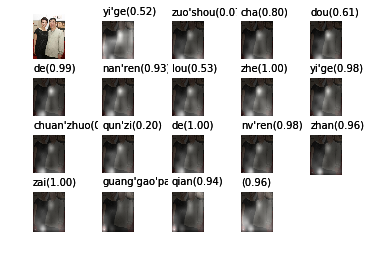

beam search using time(ms): 1695.28388977
一个 右手 插 兜 的 男人 搂 着 一个 穿着 裙子 的 女人 站 在 展板 前 </S> 0.0106948
beam search using time(ms): 45.9640026093
一个 左手 插 兜 的 男人 搂 着 一个 面带微笑 的 女人 站 在 广告牌 前 </S> 0.0105547
beam search using time(ms): 22.7100849152
一个 左手 插 兜 的 男人 搂 着 一个 穿着 裙子 的 女人 站 在 展板 前 </S> 0.00997953
beam search using time(ms): 17.5220966339
一个 右手 插 兜 的 男人 搂 着 一个 右手 插 兜 的 男人 站 在 广告牌 前 </S> 0.007927
beam search using time(ms): 17.4379348755
一个 左手 插 兜 的 男人 搂 着 一个 右手 插 兜 的 男人 站 在 广告牌 前 </S> 0.0074165
beam search using time(ms): 19.7370052338
一个 右手 插 兜 的 男人 搂 着 一个 面带微笑 的 女人 站 在 室内 </S> 0.00714229
beam search using time(ms): 25.5100727081
一个 右手 插 兜 的 男人 搂 着 一个 左手 插 兜 的 男人 站 在 广告牌 前 </S> 0.00711406
beam search using time(ms): 20.0707912445
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 7763199d7d02eec0cabc5c05aefb5bba531ac268


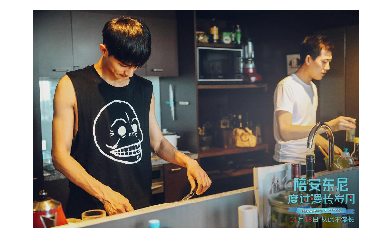

一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 厨房 里 </S> 0.0144165
probs [0.34341805062750763, 0.3073484337944721, 0.36492965129252186, 0.7331858365344469, 0.9916356610334498, 0.7817907778851184, 0.6997018497557834, 0.9689252567189419, 0.5619511037172089, 0.35290038005291635, 0.7748745173354133, 0.9940376285443154, 0.8663915193873042, 0.4195325861406679, 0.9976238578196499, 0.23674507697511482, 0.9148673363208037, 0.9059170543548191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


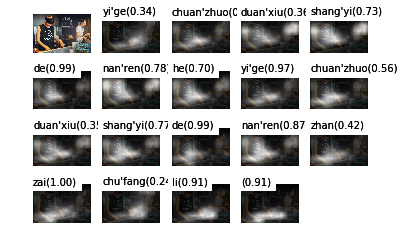

beam search using time(ms): 2618.65282059
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 屋子里 </S> 0.0112929
probs [0.34341805062750763, 0.3073484337944721, 0.36492965129252186, 0.7331858365344469, 0.9916356610334498, 0.7817907778851184, 0.6997018497557834, 0.9689252567189419, 0.5619511037172089, 0.35290038005291635, 0.7748745173354133, 0.9940376285443154, 0.8663915193873042, 0.4195325861406679, 0.9976238578196499, 0.1532052427096869, 0.8829008648338048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


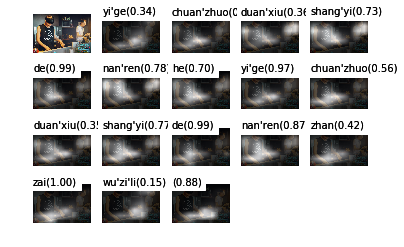

beam search using time(ms): 1714.99609947
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 房间 里 </S> 0.0112299
probs [0.34341805062750763, 0.3073484337944721, 0.36492965129252186, 0.7331858365344469, 0.9916356610334498, 0.7817907778851184, 0.6997018497557834, 0.9689252567189419, 0.5619511037172089, 0.35290038005291635, 0.7748745173354133, 0.9940376285443154, 0.8663915193873042, 0.4195325861406679, 0.9976238578196499, 0.13776031363559696, 0.9709416869303913, 0.8769121254026223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


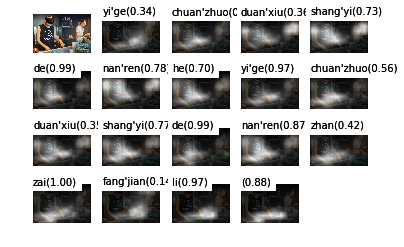

beam search using time(ms): 1838.82904053
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 在 厨房 里 交谈 </S> 0.00891243
beam search using time(ms): 49.8039722443
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 房屋里 </S> 0.00889236
beam search using time(ms): 25.1579284668
一个 穿着 白色 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 厨房 里 </S> 0.00848147
beam search using time(ms): 24.246931076
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 在 屋子里 交谈 </S> 0.00830369
beam search using time(ms): 23.5462188721
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 在 房间 里 交谈 </S> 0.00806993
beam search using time(ms): 24.9028205872
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 在 厨房 里 握手 </S> 0.00667336
beam search using time(ms): 25.465965271
一个 穿着 短袖 上衣 的 男人 和 一个 穿着 短袖 上衣 的 男人 站 在 室内 </S> 0.00660266
beam search using time(ms): 23.6082077026
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: cd674e0e2b4644d6fb83e80fc9c6a530d874a5dc


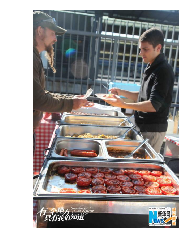

一个 戴着 帽子 的 男人 和 一个 戴着 眼镜 的 男人 站 在 室外 的 桌子 旁 </S> 0.00497116
probs [0.22606135194431215, 0.23078551347963833, 0.42592154012227745, 0.9803661670556709, 0.8215594102276749, 0.604521446805623, 0.9080620300568155, 0.3705978327522126, 0.3714998650618828, 0.991364011558225, 0.7336667082540056, 0.4168356082471306, 0.9970286232296942, 0.24111315621040458, 0.7103266908688213, 0.32960252795725664, 0.9215567884465966, 0.8461797428556056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


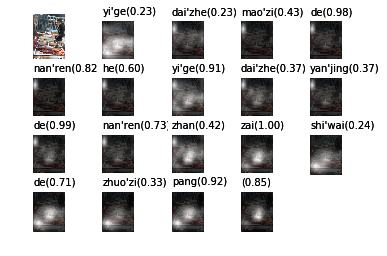

beam search using time(ms): 2052.96182632
一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 男人 站 在 室外 的 桌子 旁 </S> 0.00445906
probs [0.22606135194431215, 0.23078551347963833, 0.42592154012227745, 0.9803661670556709, 0.8215594102276749, 0.604521446805623, 0.9080620300568155, 0.3705978327522126, 0.3034141676055771, 0.9911435661159685, 0.7234892994489304, 0.4155780986964853, 0.9970759075456485, 0.24167452574006462, 0.7091509858361825, 0.328862044800977, 0.9213580971101726, 0.8440504359999909, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


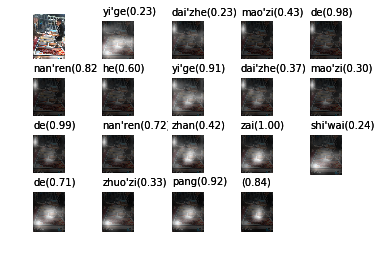

beam search using time(ms): 1402.98008919
一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 站 在 室外 的 桌子 旁 </S> 0.00437486
probs [0.22606135194431215, 0.23078551347963833, 0.3266899712183848, 0.9804157790971423, 0.8297663936597071, 0.6050147498045486, 0.9073961614478355, 0.3702444612507583, 0.3705042961517646, 0.9913077780341929, 0.7296021595215612, 0.4161822412264401, 0.9970365628730948, 0.24149346608020303, 0.7099542073883048, 0.3299881655013481, 0.9215969836664868, 0.8466203298368133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


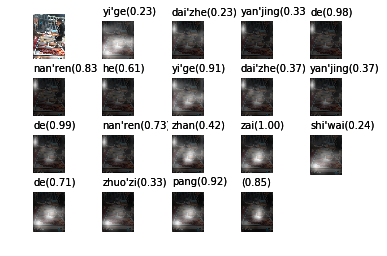

beam search using time(ms): 1381.78396225
一个 戴着 眼镜 的 男人 和 一个 戴着 帽子 的 男人 站 在 室外 的 桌子 旁 </S> 0.00392748
beam search using time(ms): 40.3270721436
一个 戴着 帽子 的 男人 和 一个 戴着 眼镜 的 男人 站 在 房屋 外 </S> 0.00281333
beam search using time(ms): 17.0130729675
室外 有 一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 男人 在 制作 食物 </S> 0.00275262
beam search using time(ms): 16.5348052979
一个 戴着 帽子 的 男人 和 一个 戴着 眼镜 的 男人 站 在 室外 </S> 0.0023527
beam search using time(ms): 39.0682220459
一个 戴着 帽子 的 男人 和 一个 戴着 眼镜 的 男人 站 在 房屋 前 </S> 0.00229142
beam search using time(ms): 39.7529602051
一个 戴着 帽子 的 男人 和 一个 戴着 眼镜 的 男人 站 在 房屋 外 的 桌子 旁 </S> 0.00222517
beam search using time(ms): 17.0500278473
一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 男人 站 在 室外 </S> 0.00209425
beam search using time(ms): 39.2107963562
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: cc2ba9324f18367869fd193c0919815ef3a89b8b


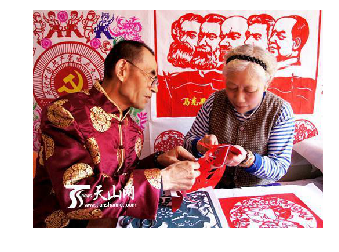

一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 在 房间 里 交谈 </S> 0.00321612
probs [0.2466323071254018, 0.09873971429109392, 0.8840965768573914, 0.9848211416577121, 0.7157994173002225, 0.7041686282764963, 0.9884967725546997, 0.09496891909173931, 0.8401008771802152, 0.9941305750739706, 0.7035672206244076, 0.5731243638559337, 0.1805491182962125, 0.9334521788660016, 0.1826063519273259, 0.99473603650557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


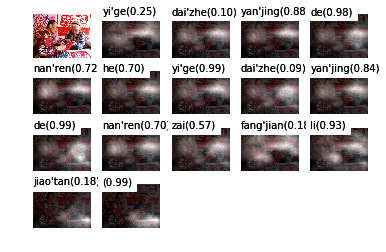

beam search using time(ms): 1591.09091759
一个 戴着 眼镜 的 男人 和 一个 穿着 裙子 的 女人 在 房间 里 交谈 </S> 0.0028432
probs [0.2466323071254018, 0.09873971429109392, 0.8840965768573914, 0.9848211416577121, 0.7157994173002225, 0.7041686282764963, 0.9884967725546997, 0.477007393346331, 0.09609104016836983, 0.9978825677878278, 0.7503881610191547, 0.7392841158368657, 0.17307618032125177, 0.9463495470817898, 0.18497612967357993, 0.9953637303145614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


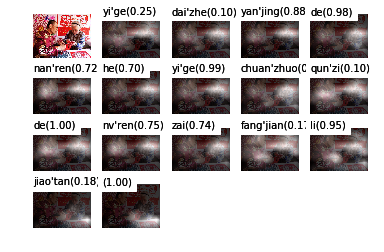

beam search using time(ms): 992.35200882
一个 戴着 眼镜 的 男人 和 一个 穿着 深色 上衣 的 男人 在 房间 里 交谈 </S> 0.00215398
probs [0.2466323071254018, 0.09873971429109392, 0.8840965768573914, 0.9848211416577121, 0.7157994173002225, 0.7041686282764963, 0.9884967725546997, 0.477007393346331, 0.1525230904722564, 0.31740909547265134, 0.9983061680663243, 0.7466327711018257, 0.6167689610365722, 0.19612360112939395, 0.9340121702341879, 0.18819032948850545, 0.994800563296956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


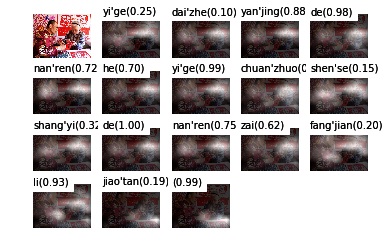

beam search using time(ms): 1081.54010773
一个 戴着 眼镜 的 男人 和 一个 穿着 深色 衣服 的 男人 在 房间 里 交谈 </S> 0.00213589
beam search using time(ms): 32.9909324646
一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 在 室内 的 桌子 旁 交谈 </S> 0.00169241
beam search using time(ms): 8.43906402588
一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 在 室内 的 桌子 旁 交流 </S> 0.00131272
beam search using time(ms): 9.10997390747
屋子里 </S> 0.00130209
beam search using time(ms): 40.3690338135
一个 戴着 眼镜 的 男人 和 一个 穿着 裙子 的 女人 在 房间 里 共同 </S> 0.00124911
beam search using time(ms): 36.3898277283
一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 在 房间 里 共同 </S> 0.00124115
beam search using time(ms): 9.5911026001
一个 戴着 眼镜 的 男人 和 一个 穿着 裙子 的 女人 在 室内 的 桌子 旁 交谈 </S> 0.00124033
beam search using time(ms): 9.57989692688


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)